# Citation & Precedent Network
 **"Legal citations:"**

Just like academic papers cite other papers, court decisions cite previous decisions or legislation.

Example: “In accordance with Article 12 of [Case XYZ], the court ruled…”

These citations show influence: which cases are relied upon the most.

**"Precedent:"**

In common law (and sometimes in civil law), past court decisions guide future ones.

A case that is cited often becomes a key precedent, shaping legal reasoning.

**Network perspective:**

Treat cases as nodes and citations as directed edges.

If Case A cites Case B, draw an arrow from A → B.

This creates a graph/network of influence:

Nodes: court decisions or statutes

Edges: citations from one case to another

# Why is it important?

Identify most influential cases (hubs).

Understand legal reasoning chains.

Detect clusters of related cases (e.g., all cases about detention conditions).

Analyze propagation of legal principles over time or across jurisdictions.

In [3]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.3 MB/s eta 0:00:0000:0100:01


In [4]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv("/kaggle/input/preprocessed-dataset/df_train_cleaned.csv")

In [7]:
print(df.columns)

Index(['case_id', 'case_no', 'title', 'judgment_date', 'facts', 'applicants',
       'defendants', 'allegedly_violated_articles', 'violated_articles',
       'court_assessment_references', 'silver_rationales', 'gold_rationales',
       'text', 'outcome', 'text_length', 'clean_text', 'clean_text_length'],
      dtype='object')


# Use 'court_assessment_references' as citations column
# Convert string to list if needed

In [8]:
import ast

# If the column is a string representation of a list
if df['court_assessment_references'].dtype == object:
    try:
        df['citations'] = df['court_assessment_references'].apply(
            lambda x: ast.literal_eval(x) if pd.notnull(x) else []
        )
    except:
        # If not a literal list, split by common delimiters (comma, semicolon)
        df['citations'] = df['court_assessment_references'].fillna("").apply(lambda x: x.split(";"))
else:
    df['citations'] = df['court_assessment_references']
    
# Check
print(df[['case_id','citations']].head())


     case_id                                          citations
0  001-59587  {'8': ['12', '140', '155', '156', '157', '158'...
1  001-59591  {'6': ['12', '15', '24', '25', '26', '27', '28...
2  001-59590  {'6': ['13', '14', '35', '40', '41', '42', '43...
3  001-59588                                     {'10': ['35']}
4  001-59589  {'6': ['13', '14', '35', '40', '41', '42', '43...


In [9]:
#Build directed citation network
import networkx as nx

G = nx.DiGraph()

for idx, row in df.iterrows():
    case_id = row['case_id']
    for cited_case in row['citations']:
        cited_case = cited_case.strip()
        if cited_case:  # skip empty
            G.add_edge(case_id, cited_case)

print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")


Total nodes: 5654
Total edges: 8541


In [23]:
# Most cited cases (in-degree)
in_degree = dict(G.in_degree())
top_cited = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most cited cases:")
for case, count in top_cited:
    print(case, count)
#Top 10 Cases That Cite Most Others (Out-Degree)
top_citing = sorted(dict(G.out_degree()).items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Most Citing Cases:")
for case, count in top_citing:
    print(f"{case}: cites {count} other cases")


# PageRank (influence)
pagerank = nx.pagerank(G)
top_influential = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 influential cases (PageRank):")
for case, score in top_influential:
    print(case, round(score, 4))

Top 10 most cited cases:
6 2269
3 1131
5 1075
41 849
8 640
13 546
P1-1 498
2 436
10 246
X 207
Top 10 Most Citing Cases:
001-94200: cites 8 other cases
001-94206: cites 8 other cases
001-95300: cites 8 other cases
001-94204: cites 7 other cases
001-96549: cites 7 other cases
001-76684: cites 6 other cases
001-91499: cites 6 other cases
001-122697: cites 6 other cases
001-146044: cites 6 other cases
001-158352: cites 6 other cases

Top 10 influential cases (PageRank):
6 0.1405
3 0.0598
5 0.0587
41 0.0384
8 0.034
P1-1 0.0268
2 0.0249
13 0.0218
10 0.0166
X 0.0089


In [25]:
df_top = pd.DataFrame({
    "CaseID": [c[0] for c in top_cited],
    "InDegree": [c[1] for c in top_cited],
    
    "PageRank": [pagerank[c[0]] for c in top_cited]
})

df_top.to_csv("top_cited_cases.csv", index=False)
print("Top cited cases saved to top_cited_cases.csv")

print("\nCitation network analysis complete!")

Top cited cases saved to top_cited_cases.csv

Citation network analysis complete!


In [26]:
# Create a DataFrame for all cases with in-degree and PageRank
df_citations = pd.DataFrame({
    "CaseID": list(G.nodes()),
    "InDegree": [G.in_degree(n) for n in G.nodes()],
    "OutDegree": [G.out_degree(n) for n in G.nodes()],
    "PageRank": [pagerank[n] for n in G.nodes()]
})

# Optional: save to CSV
df_citations.to_csv("all_cited_cases.csv", index=False)

# Quick check
print(df_citations.head(20))



       CaseID  InDegree  OutDegree  PageRank
0   001-59587         0          3  0.000096
1           8       640          0  0.033951
2          13       546          0  0.021782
3          41       849          0  0.038354
4   001-59591         0          2  0.000096
5           6      2269          0  0.140492
6        P1-1       498          0  0.026761
7   001-59590         0          2  0.000096
8   001-59588         0          1  0.000096
9          10       246          0  0.016594
10  001-59589         0          2  0.000096
11  001-59603         0          1  0.000096
12  001-59594         0          1  0.000096
13  001-59592         0          3  0.000096
14          2       436          0  0.024876
15          5      1075          0  0.058680
16  001-59604         0          1  0.000096
17  001-59608         0          3  0.000096
18          3      1131          0  0.059787
19         34        61          0  0.002349


In [32]:
# Make sure df_train has dominant_topic
print(df.columns)

#

Index(['case_id', 'case_no', 'title', 'judgment_date', 'facts', 'applicants',
       'defendants', 'allegedly_violated_articles', 'violated_articles',
       'court_assessment_references', 'silver_rationales', 'gold_rationales',
       'text', 'outcome', 'text_length', 'clean_text', 'clean_text_length',
       'citations'],
      dtype='object')


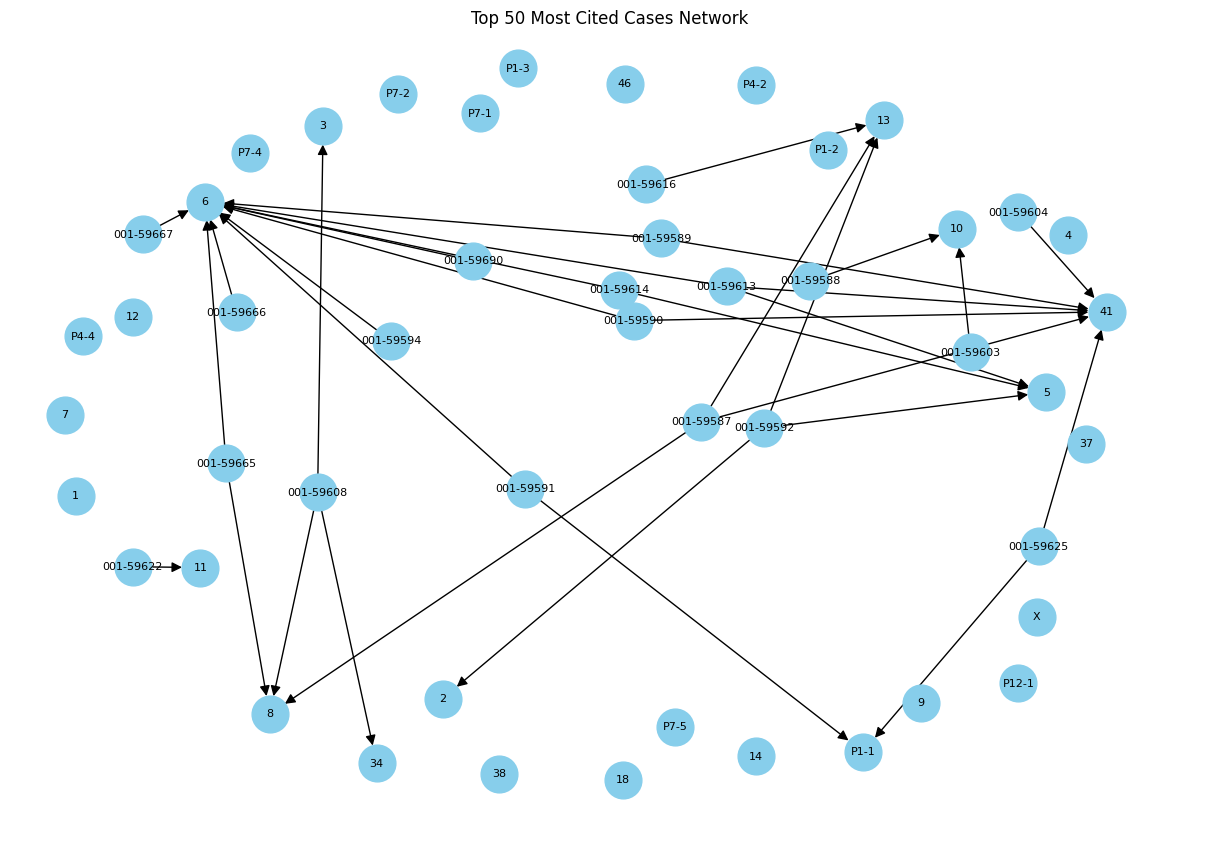

In [33]:
# Top 50 most cited cases
top_cases = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:50]
top_nodes = [c[0] for c in top_cases]

H = G.subgraph(top_nodes)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(H, k=0.5)  # force-directed layout
nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=8, arrowsize=15)
plt.title("Top 50 Most Cited Cases Network")
plt.show()


the focus was on analyzing citations and precedent networks in court decisions. Each case was represented as a node in a directed graph, and citations between cases were represented as edges. This allowed us to quantify relationships between judgments, showing which cases serve as precedents and which cases reference others. By transforming raw legal text into a structured network, we were able to uncover patterns of influence that would be difficult to see manually.

We calculated several key network metrics for each case. InDegree measured how many times a case was cited by others, identifying highly influential or frequently referenced decisions. OutDegree captured how many citations a case made, indicating cases that actively reference prior judgments. Additionally, PageRank was computed to assess the overall importance of each case in the network, accounting for both the number and significance of citations it received. Sorting cases by these metrics highlighted the most influential judgments within the dataset.

The network was visualized by plotting the top 20 most cited cases. While this provided a quick glimpse of key precedents, the visualization appeared somewhat disconnected. This is because many top-cited cases do not directly cite each other; citations often point to less-cited or older cases outside the top 20. Despite this limitation, the approach successfully identified influential cases and quantified their role in shaping legal precedent.

Overall, this analysis is valuable because it provides a structured and quantifiable view of the legal landscape. It complements the topic and trend analysis performed in previous notebooks by offering insights into which cases carry legal authority and how influence propagates across judgments. The main limitations include the basic visualization, lack of integration with topic labels, and the static nature of the network. Future improvements could include interactive network visualizations, integrating topic information to see which themes drive citations, and analyzing temporal dynamics to track how precedent evolves over time.